Trying to decouple sample error and distribution shift

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from simple_data import *

In [2]:
def get_scores(model_type='linear', p=1):
    train_scores = []
    test_scores = []
    ns = [2**i for i in range(5, 13)]
    print(ns)
    for n in ns:
        if model_type == 'linear':
            X, y = get_data(n, p)
            model = LinearRegression()
            cv = ShuffleSplit(n_splits=300, test_size=0.3, random_state=0)
        elif model_type == 'logistic':
            X, y_one_hot, y = generate_gaussian_data(n)
            y = y.astype(np.int)
            model = LogisticRegression(solver='lbfgs')
            cv = StratifiedShuffleSplit(n_splits=300, test_size=0.3, random_state=0)
        
        results = cross_validate(model, X, y.flatten(), cv=cv, return_train_score=True)
        train_scores.append(results['train_score'])
        test_scores.append(results['test_score'])

    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)
    return ns, train_scores, test_scores

# logistic regression in 1d

In [143]:
ns, train_scores, test_scores = get_scores(model_type='logistic')

[32, 64, 128, 256, 512, 1024, 2048, 4096]


train...


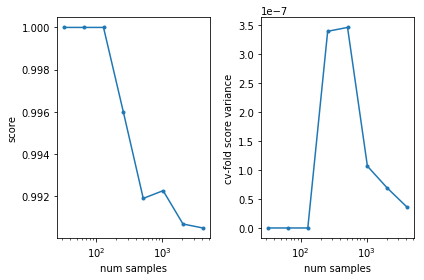

test...


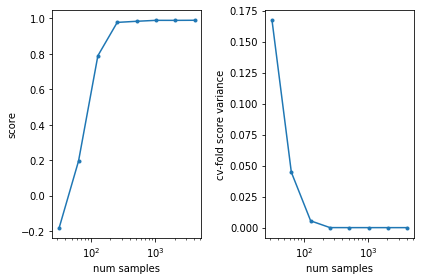

In [152]:
def plot_scores(scores):
    R, C = 1, 2
    plt.subplot(R, C, 1)
    plt.plot(ns, np.mean(scores, axis=1), '.-')
    plt.xscale('log')
    plt.xlabel('num samples')
    plt.ylabel('score')

    plt.subplot(R, C, 2)
    plt.plot(ns, np.var(scores, axis=1), '.-')
    plt.xscale('log')
    plt.xlabel('num samples')
    plt.ylabel('cv-fold score variance')

    plt.tight_layout()
    plt.show()

print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)

# linear reg in low dim

In [148]:
ns, train_scores, test_scores = get_scores(model_type='linear')

[32, 64, 128, 256, 512, 1024, 2048, 4096]


train...


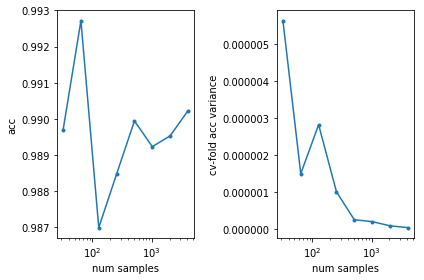

test...


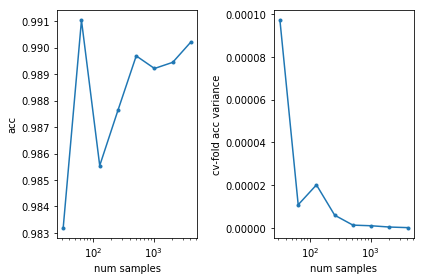

In [149]:
print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)

# linear reg in high dim

[32, 64, 128, 256, 512, 1024, 2048, 4096]
train...


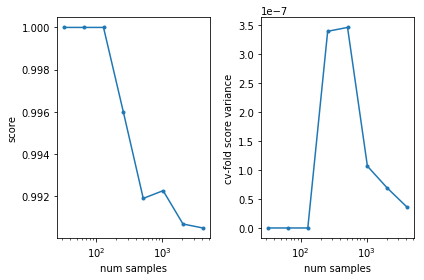

test...


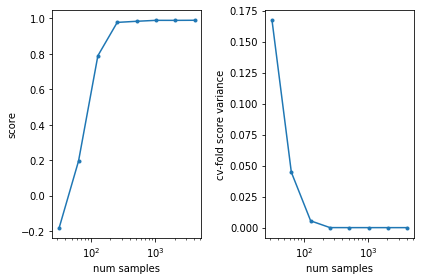

In [153]:
ns, train_scores, test_scores = get_scores(model_type='linear', p=100)

print('train...')
plot_scores(train_scores)
print('test...')
plot_scores(test_scores)